In [ ]:
#Applicable only if you are building it on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random

In [ ]:
def segment_blobs(image, colour, mask = None):   # mask is used whenever thresholding is to be performed in a region smaller than the size of 'image'
    # BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  
    if colour == 'y': # yellow
        lower = np.array([16,101,172])
        upper = np.array([29,255,255])
    elif colour == 'w': # white
        lower = np.array([120,100,100], dtype=np.uint8)
        upper = np.array([255,140,140], dtype=np.uint8)
    elif colour == 'k': # black
        lower = np.array([0,101,91], dtype=np.uint8)
        upper = np.array([120,140,156], dtype=np.uint8)
    elif colour == 'b':   # blue
        lower = np.array([71,101,172])
        upper = np.array([121,255,255])
    elif colour == 'c': # chocolate-coloured or brown
        lower = np.array([10,217,99], dtype=np.uint8)
        upper = np.array([25,255,198], dtype=np.uint8)
    elif colour == 'g': # green
        lower = np.array([70,90,90], dtype=np.uint8)
        upper = np.array([85,255,255], dtype=np.uint8)
    elif colour == 'r': # red
        lower = np.array([0,150,100], dtype=np.uint8)
        upper = np.array([255,255,255], dtype=np.uint8)
    elif colour == 'i': # blackandwhite
        lower = np.array([0,100,100], dtype=np.uint8)
        upper = np.array([255,150,150], dtype=np.uint8)
            
    img_range = cv2.inRange(image, lower, upper)
    # plt.imshow(img_range)
    # plt.show()
        
    return img_range
    

In [ ]:
# setting the root directories and categories of the images
# root_dir = './images_background/'
root_dir = "/content/drive/MyDrive/Traffic sign segmentation/Oneshot/Triangle/"
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [ ]:
from numpy.core.fromnumeric import ndim
def concat_images(X,istensor=True):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""

    nc=len(X)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    w=160
    h=160
    print(X[0].shape[1])
    if X[0].shape[1]==3:
      img = np.zeros((n*w,n*h,3),dtype=np.uint8)
    elif X[0].shape[1]==1:
      img = np.zeros((n*w,n*h),dtype=np.uint8)
    x = 0
    y = 0
    col=None
    rowfull=False
    colfull=False
    row=None
    for unit,data in enumerate(X):
      if istensor:
        _,_,w,h=X[unit].shape
        
      else:
        if X[unit].shape[1]==3:
          w,h,_=X[unit].shape
        elif X[unit].shape[1]==1:
          w,h  = X[unit].shape
      # print(w,h)
     
    
        # print(X[example].shape)
      # print(w,h)
      if istensor:
        g=datatoimage(data)
      else:
        g=data
      # print(g.shape)
      col=unit%n+1
      row=int(unit/n)+1
      font = cv2.FONT_HERSHEY_SIMPLEX
  
      # org
      org = (0, 30)
      # fontScale
      fontScale = 1      
      # Blue color in BGR
      color = (127)
        
      # Line thickness of 2 px
      thickness = 2
        
      # Using cv2.putText() method
      g = cv2.putText(g, str(unit), org, font, 
                        fontScale, color, thickness, cv2.LINE_AA)
      
      img[(row-1)*(w):(row)*(w),(col-1)*h:col*h]=g
               
    return img
        
      
    
from google.colab.patches import cv2_imshow
def plot_oneshot_task(mainImg,montage,label):
  # print(label)
  
  disp=cv2.resize(mainImg,(montage.shape[1],montage.shape[0]))
  combined=np.concatenate((montage,disp),1)
  combined=image_resize(combined,width=montage.shape[1])
  # combined=cv2.cvtColor(combined,cv2.COLOR_RGB2BGR)
  cv2_imshow(combined)
  
def datatoimage(mainImg):
  mainImg=mainImg[0]
  mainImg=mainImg.permute(1,2,0) 
  if torch.cuda.is_available():
    norm_image = cv2.normalize(mainImg.cpu().numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
  else:
     norm_image = cv2.normalize(mainImg.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
  return norm_image


In [ ]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [ ]:
debug=False
from tempfile import template
# from tempfile import template
def getsign(norm_image): # Take in an image and give the balck parts template and the centered sign as output for use in template matching
  # norm_image =  cv2.fastNlMeansDenoisingColored(norm_image.astype(np.uint8),None,10,10,7,21)
  red = segment_blobs(norm_image,"r")
  # plt.imshow(red)
  # plt.show()
  
  redpts  = gettripoints(norm_image,red)# Extract red mask and red points from image
  zero    = np.zeros((red.shape),dtype=np.uint8)		
  trimask = cv2.fillConvexPoly(zero,redpts,255) # Fill the area enclosed by red points to help crop triangular sign part from the image
  trimask = wrap_center(trimask,redpts)
  disp_image = wrap_center(norm_image,redpts) 
  sign = cropROI(trimask,disp_image)
  
  if debug==True:
    print("wrapped image")
    print(trimask.shape,norm_image.shape)
    plt.imshow(trimask)
    plt.show()
  trimask=cropROI(trimask,trimask)#Crop the outputmask to be the same size as the image
  return sign,trimask

def whiteout(norm_image,istemp,ROIMask):
  norm_image=norm_image.astype(np.uint8)
  notROI=np.bitwise_not(ROIMask)#Invert the incoming ROI Mask
  white = segment_blobs(norm_image,'w')# Extract white mask 
  
  black = segment_blobs(norm_image,"k")# Extract black mask 
  notblack  = np.bitwise_not(black)
  if debug==True:
    print("NOTROI")
    plt.imshow(notROI)
    plt.show()
    print("Notblack")  
    plt.imshow(notblack)
    plt.show()

  notblack  = (notblack|notROI)   #Include the area that is black but not in ROI also in the whiteout mask
  if debug==True:
    print("OR BLACK")
    plt.imshow(notblack)
    plt.show()
    
    print("White")
    plt.imshow(white)
    plt.show()
    
    print("Not White")
    plt.imshow(notblack)
    plt.show()
  white_tri = cv2.bitwise_and(norm_image,norm_image , mask=white)
  
  avg=np.nonzero(white_tri)
  avg_arr=np.asarray(avg)
  
  # print(avg_arr)
  
  avgpix=np.median(white_tri[avg_arr[0],avg_arr[1]],axis=0).astype(int)
  avgpix=[255,255,255]
  image=norm_image.copy()
  image[np.where(notblack.astype(np.bool))]=avgpix
  
  
  if debug==True:
    print("Whiteout")
    plt.imshow(image)
    plt.show()
  
  return image


def gettemplate(norm_image):
  norm_image=norm_image.astype(np.uint8)
  # norm_image =  cv2.fastNlMeansDenoisingColored(norm_image,None,10,10,7,21)
  red = segment_blobs(norm_image,"r")
  # contours, hierarchy = cv2.findContours(red.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # if len(contours) != 0:
  #       c = max(contours, key = cv2.contourArea)
  #       x,y,w,h = cv2.boundingRect(c)
  #       # cv2.rectangle(norm_image,(x,y),(x+w,y+h),(0,255,0),2)
  # cv2_imshow(norm_image)
  if debug==True:
    print("red")
    plt.imshow(red)
    plt.show()
  if np.count_nonzero(red)==0:
     print('inside')
     red = np.bitwise_not(red)
  
  # print(cv2.goodFeaturesToTrack(red,3,0.01,10))
  redpts  = gettripoints(norm_image,red)# Extract red mask and red points from image
  zero    = np.zeros((red.shape),dtype=np.uint8)		
  trimask = cv2.fillConvexPoly(zero,redpts,255) # Fill the area enclosed by red points to help crop triangular sign part from the image
  resi = cv2.bitwise_and(norm_image,norm_image , mask=trimask) #Extract the part of image within that triangle
  blackwhite = segment_blobs(resi,'i')# Extract black+white mask 
  bwdenoised = cv2.bitwise_and(blackwhite,trimask) 
  
  realpts = gettripoints(resi,bwdenoised) #Get black+white points from image

  disp_image = wrap_center(norm_image,redpts) 
  black_mask = segment_blobs(norm_image,"k")
  # plt.imshow(black_mask)
  # plt.show()
  
  if np.count_nonzero(black_mask)==0:
     black_mask = np.bitwise_not(black_mask)
  black_mask = wrap_center(black_mask,redpts)
  


  trimask = wrap_center(trimask,redpts)
  combs= np.bitwise_and(black_mask,trimask)# BLack color filtered inside the triangle
  if debug==True:
    print("wrapped image")
    plt.imshow(combs)
    plt.show()
  template=cropROI(combs,disp_image)
  combs=cropROI(combs,combs)
  return template,combs
  

def gettripoints(image,img_thresh1):# Gives the red mask and triangle corner points to crop the image
  # plt.imshow(img_thresh1)
  # plt.show()
  idx = np.argwhere(img_thresh1)
  sum= np.sum(idx,axis=1)
  x_min = np.amin(idx[:,0])
  x_max = np.argmax(idx[:,0])
  y_min = np.amin(idx[:,1])
  y_max = np.argmax(idx[:,1])
  tidx   = np.where(idx[:,0]==x_min)
  yidx = np.where(idx[:,1]==y_min)
  
  top   = [x_min,int(np.average(idx[tidx,1]))]
  
  left  = [int(np.amax(idx[yidx,0])),y_min]
  right = idx[y_max]

  # print(f"Top Corner x : {top[0]} , y : {top[1]} ")
  # print(f"Bottom Left Corner x : {left[0]} , y : {left[1]} ")
  # print(f"Bottom Right Corner x : {right[0]} , y : {right[1]} ")

  pts1=[top,right,left]
  pts1=np.asarray(pts1,dtype=np.float32)
 
  # plt.imshow(image)
  # plt.show()
  pts=np.array([(top[1],top[0]),(right[1],right[0]),(left[1],left[0])])
  return pts
def wrap_center(image,pts):
  top,right,left=pts
  pts1=np.array([(top[0],top[1]),(right[0],right[1]),(left[0],left[1])])
  m=((image.shape[1]/2))
  topc  = [m,0]
  leftc = [0,105]
  rightc= [105,105]
  pts2=(topc,rightc,leftc)
  pts2=np.asarray(pts2,dtype=np.float32)
  pts1=np.asarray(pts1,dtype=np.float32)
  # print("PTS1",pts1)
  # print("PTS2",pts2)
  warp_mat = cv2.getAffineTransform(pts1, pts2)
  warp_dst = cv2.warpAffine(image, warp_mat, (image.shape[1], image.shape[0]))
  	
  return warp_dst

# showing a sample input of the testing set
count = 0
def cropROI(black,image):
  idx = np.argwhere(black)
  
  x_min = np.amin(idx[:,0])
  x_max = np.amax(idx[:,0])
  y_min = np.amin(idx[:,1])
  y_max = np.amax(idx[:,1])
  if image.ndim==3:
    template=image[x_min:x_max,y_min:y_max,:]
  elif image.ndim==2:
    template=image[x_min:x_max,y_min:y_max]
  return template



In [ ]:
def piltocv(pil_image):
  
  open_cv_image = np.array(pil_image) 
  open_cv_image = open_cv_image[:, :, ::-1].copy() 
  open_cv_image = cv2.resize(open_cv_image,(105,105))

  return open_cv_image
def cvtopil(cv2img):
  cv2img = cv2.cvtColor(cv2img.astype(np.uint8), cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(cv2img.astype(np.uint8))

  return im_pil
def applywhiteout(img1,istemp):

  img1 = piltocv(img1)

  try:
    if istemp:
      img1,mask1 = gettemplate(img1)
    else:
      img1,mask1 = getsign(img1) 

    img1 = whiteout(img1,1,mask1)
    img1=np.where(img1>127,255,0)
  except:
    pass
  finally:
    img1 = cvtopil(img1)
    
  return img1
        


In [ ]:
# creating the pairs of images for inputs, same character label = 1, vice versa
class OmniglotDataset(Dataset):
    def __init__(self, categories, root_dir, setSize, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        training_list=categories[1][1]
        train_path = os.path.join(root_dir,"Training/")
        train_folders = os.listdir(train_path)

        if idx % 2 == 0: # select the same character for both images
            
            category = random.choice(training_list)
            # print(training_list)
            
            imgDir = root_dir + "Training" + '/' + category
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img1 = img1.convert("L")
            img2 = Image.open(imgDir + '/' + img2Name)
            img2 = img2.convert("L")
            # print(imgDir+'/'+img1Name)
            # print(imgDir+'/'+img2Name)
            label = 1.0
        else: # select a different character for both images
            
            category1 = random.choice(training_list)
            training_different=training_list.copy()
            # print(category1,len(training_different))
            training_different.remove(category1)
            category2 = random.choice(training_different)
            # print(category2,len(training_different))
            imgDir1, imgDir2 = root_dir + "Training" + '/' + category1, root_dir + "Training" + '/' + category2
            
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))

            label = 0.0
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img1 = img1.convert("L")
            img2 = Image.open(imgDir2 + '/' + img2Name)
            img2 = img2.convert("L")
        # img1=applywhiteout(img1,istemp=1)
        # img2=applywhiteout(img2,istemp=1)         
#         plt.imshow(img1)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        # print("Image1:",img1.shape)
        # print("Image2:",img1.shape)
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))          


In [ ]:
# creates n-way one shot learning evaluation
class NWayOneShotEvalSet(Dataset):
    def __init__(self, categories, root_dir, setSize, numWay, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.setSize = setSize
        self.numWay = numWay
        self.transform = transform
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        # find one main image
        test_path  = os.path.join(root_dir,"Testing/")
        train_path = os.path.join(root_dir,"Training/")
        test_folders = os.listdir(test_path)
        train_folders = os.listdir(train_path)
        paths=[img_path for img_path in test_folders]
        if idx>27:
          idx=idx%28
        test_name=paths[idx]
        sign_path= random.choice(os.listdir(os.path.join(test_path,test_name)))
        mainImg = Image.open(os.path.join(test_path,test_name,sign_path))
        mainImg = mainImg.convert("RGB")
        # print(imgDir + '/' + imgName)
        # mainImg=applywhiteout(mainImg,istemp=1)
        if self.transform:
            mainImg = self.transform(mainImg)
        
        # print(imgDir + '/' + imgName)
        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        label = train_folders.index(test_name)
        
        # print(len(paths))
        # print(paths)
        for i,sign_name in enumerate(train_folders):
                # print("Train",sign_name)
            path=os.path.join(train_path,sign_name)
                # print(path)
            candidates=os.listdir(path)
                # print("Candidates",candidates)
            candidate=random.choice(candidates)
                # print("Candidate",candidate)
            candidate_path = os.path.join(train_path,sign_name,candidate)
            
            testImg = Image.open(candidate_path)
            testImg = testImg.convert("RGB")
            # testImg=applywhiteout(testImg,istemp=1)
            if self.transform:
                testImg = self.transform(testImg)
            imgdata=[testImg,sign_name]

            testSet.append(imgdata)
        # plt.imshow()
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))

In [ ]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 1500 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

transformations = transforms.Compose(
    [transforms.Resize((100,100)),transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, dataSize, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=52, num_workers=2,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=2, shuffle=True)

NameError: ignored

In [ ]:
# create the test set for final testing
testSize = 1500
numWay = 50
trans=transforms.Compose([transforms.Resize((160,160)),transforms.ToTensor()])
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 1, shuffle=False)

In [ ]:
for i in range(2):
  mainImg, imglist, label =next(iter(test_loader))
  imgset,impath=list(map(list, zip(*imglist)))
  print("Label Image")
  plt.imshow(datatoimage(imgset[label]))
  plt.show()
  print(impath[label])
  norm_image = datatoimage(mainImg)
  plt.imshow(norm_image)
  plt.show()
  # template,tempmask = gettemplate(norm_image)
  # sign  ,signmask   = getsign(norm_image)
  # print(sign.shape,norm_image.shape)
  # plt.imshow(sign)
  # plt.show()
  # plt.imshow(template)
  # plt.show()



  istemp=1
  issign=0
  # whitesign= whiteout(sign,istemp,signmask)
  # whitetemp= whiteout(template,issign,tempmask)
  try:
    sign     = getsign(norm_image)
  except:
    sign = norm_image

  try:
    print("g")
  except:
    template = norm_image

  # print("Blackwhite")

  # print(np.unique(norm_image,return_counts=True))

  if debug==True:
    plt.imshow(norm_image)
    plt.show()
    print("White sign")

    plt.imshow(whitesign)
    plt.show()
    print("White Template")
    
    plt.imshow(whitetemp)
    plt.show()
  montage=concat_images(imgset)#concatenate the list  
  plot_oneshot_task(norm_image, montage, label) #plot for oneshot learners 


Output hidden; open in https://colab.research.google.com to view.

Same Class


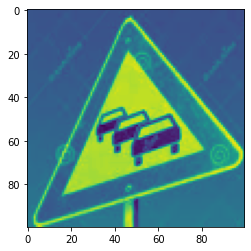

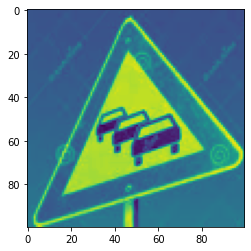

In [ ]:
# showing a sample input of a training set
count0 = 0
count1 = 0
def datatoimage(mainImg):
  mainImg=mainImg[0]
  mainImg=mainImg.permute(1,2,0)
  norm_image = cv2.normalize(mainImg.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
  return norm_image

img1, img2, label =next(iter(train_loader))
img1 = datatoimage(img1)
img2 = datatoimage(img2)
if label[0] == 1.0:
  print("Same Class")
  # plt.subplot(1,2,1)
  plt.imshow(img1)
  plt.show()
  # plt.subplot(1,2,2)
  plt.imshow(img2)
  plt.show()       
else:
  print("Different Class")
  plt.imshow(img1)
  plt.show()
  plt.imshow(img2)
  plt.show()
    # break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Different network structures, the commented out are the different experimenting structures
class GeneralNet(nn.Module):
    def __init__(self):
        super(GeneralNet, self).__init__()
        
        # Koch et al.
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*5*5,4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

        # VGG16
        # # dataiter = iter(train_loader)
        # # img1, img2, label = dataiter.next()
        # # print(img1.shape)
        # self.conv11 = nn.Conv2d(1, 64, 3) 
        # self.conv12 = nn.Conv2d(64, 64, 3)  
        # self.conv21 = nn.Conv2d(64, 128, 3)
        # self.conv22 = nn.Conv2d(128, 128, 3)
        # self.conv31 = nn.Conv2d(128, 256, 3) 
        # self.conv32 = nn.Conv2d(256, 256, 3)  
        # self.conv33 = nn.Conv2d(256, 256, 3)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(256 * 8 * 8, 4096)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.fcOut = nn.Linear(4096, 1)
        # self.sigmoid = nn.Sigmoid()
        # # x = self.conv11(img1)
        # # x = self.conv12(x)
        # # x = self.pool(x)
        # # x = self.conv21(x)
        # # x = self.conv22(x)
        # # x = self.pool(x)
        # # x = self.conv31(x)
        # # x = self.conv32(x)
        # # x = self.conv33(x)
        # # x = self.pool(x)
        # # print(x.shape)
    
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x

        # VGG16
        # x = F.relu(self.conv11(x))
        # x = F.relu(self.conv12(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv21(x))
        # x = F.relu(self.conv22(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv31(x))
        # x = F.relu(self.conv32(x))
        # x = F.relu(self.conv33(x))
        # x = F.max_pool2d(x, (2,2))
        # return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        # Koch et al.
      
        x1 = x1.view(-1,256 * 5 * 5)
      
        x1 = self.sigmoid(self.fc1(x1))

        # VGG16
        # x1 = x1.view(-1, 256 * 8 * 8)
        # x1 = self.fc1(x1)
        # x1 = self.sigmoid(self.fc2(x1))
        
        x2 = self.convs(x2)

        # Koch et al.
        x2 = x2.view(-1,256 * 5 * 5)
        x2 = self.sigmoid(self.fc1(x2))

        # VGG16
        # x2 = x2.view(-1, 256 * 8 * 8)
        # x2 = self.fc1(x2)
        # x2 = self.sigmoid(self.fc2(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [ ]:
#Different network structures, the commented out are the different experimenting structures
class TriangleNet(nn.Module):
    def __init__(self):
        super(TriangleNet, self).__init__()
        
        # Koch et al.
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*5*5,4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        # Koch et al.
      
        x1 = x1.view(-1,256 * 5 * 5)
      
        x1 = self.sigmoid(self.fc1(x1))

        
        x2 = self.convs(x2)

        # Koch et al.
        x2 = x2.view(-1,256 * 5 * 5)
        x2 = self.sigmoid(self.fc1(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [ ]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = TriangleNet()
siameseBaseLine = siameseBaseLine.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseBaseLine)

NameError: ignored

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionResnetV1(nn.Module):
    """Inception Resnet V1 model with optional loading of pretrained weights.
    Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
    datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
    requested and cached in the torch cache. Subsequent instantiations use the cache rather than
    redownloading.
    Keyword Arguments:
        pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
            (default: {None})
        classify {bool} -- Whether the model should output classification probabilities or feature
            embeddings. (default: {False})
        num_classes {int} -- Number of output classes. If 'pretrained' is set and num_classes not
            equal to that used for the pretrained model, the final linear layer will be randomly
            initialized. (default: {None})
        dropout_prob {float} -- Dropout probability. (default: {0.6})
    """
    def __init__(self, dropout_prob=0.6, device=None):
        super().__init__()


        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=False)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        """Calculate embeddings or logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)
        x = F.normalize(x, p=2.0, dim=1)
        return x
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [ ]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    
    state_dict = torch.load(save_path,map_location='cuda:0')
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    

In [ ]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    if os.path.exists(save_name):
      best_val_loss =load_checkpoint(model,optimizer,save_name)
    else:
      best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  
import imutils
from google.colab.patches import cv2_imshow
# evaluation metrics
def test(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        wrong=[]
        tcorrect=0
        triplet=TripletLoss()
        for mainImg, imglist, label in test_loader:
            imgSets,impath=list(map(list, zip(*imglist)))
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            outputs=[]
            maxes=[]
            whiteSets=[]
            centerSets=[]
            dists=[]
            
            for i, testImg in enumerate(imgSets):
                # print(impath[i])
                testImg = testImg.to(device)
                # print("before model")
                # output = model(mainImg, testImg)
                mainvec,testvec = model(mainImg),model(testImg)
                dist = triplet.calc_euclidean(mainvec,testvec)
                dists.append(dist.detach().cpu().numpy().squeeze())
                # outputs.append(output.detach().cpu())
                # print("after model")
            #     print(output)
            # print(outputs)
            print(dists)
            prediction = np.argmin(dists)  
            label = label.to(device)
            sorts = np.argsort(dists)
            top4  = sorts[-4:]
            top4=top4.tolist()
            topSet=[]
            topSet.append(imgSets[label])
            topSet.append(imgSets[prediction])
            for i in top4:
              topSet.append(imgSets[i])
            
            count += 1
            print("Orignal Images")
            montage=concat_images(topSet)
            mainImg=datatoimage(mainImg)
            plot_oneshot_task(mainImg,montage,label.to('cpu'))
            # print("After Warping")
            # montage=concat_images(centerSets,False)#concatenate the list 
            # plot_oneshot_task(template,montage,label.to('cpu'))
            # print("Whitened Images")
            # montage=concat_images(whiteSets,False)#concatenate the list 
            # plot_oneshot_task(template,montage,label.to('cpu'))
            
            
            if count % 20 == 0:
              print("Current Count is: {}".format(count))
              print('Accuracy on n way: {}'.format(correct/count))
              # print('Accuracy on template matching: {}'.format(tcorrect/count))
            if label==prediction:
              correct += 1
              print("Oneshot Correct")
            else:
              print("Not Correct")
              tupele=[mainImg,imgSets,label,prediction]
              wrong.append (tupele)

            print("Sign Details :",impath[label.to("cpu")])
            print("Oneshot Prediction :",impath[prediction])
    return wrong    



In [ ]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.00006)
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
save_path = '/content/drive/MyDrive/Traffic sign segmentation/Rectangle-weights.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

NameError: ignored

In [ ]:
# Evaluation on previously saved models
import torch.optim as optim

test_model = InceptionResnetV1().to("cuda:0")

test_optimizer = optim.Adam(test_model.parameters(), lr=0.0006)
save_path = "/content/drive/MyDrive/Traffic sign segmentation/Oneshot/Weights/Tri-Triplet_weights.pth"
best_val_loss = load_checkpoint(test_model, test_optimizer,save_path)
print(best_val_loss)
wrong=test(test_model, test_loader)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(wrong))
# save_checkpoint("/content/siameseNet-batchnorm50.pt",load_model,load_optimizer,best_val_loss)
for w in wrong:
  mainImg,ImgSets,label,prediction=w
  mainImg=datatoimage(mainImg)
  montage=concat_images(ImgSets)
  print(montage.shape)
  plot_oneshot_task(mainImg,montage.astype(np.uint8),label.to('cpu'))
  print(prediction)

57


AttributeError: ignored